In [ ]:
import sys
sys.path.append('../scripts')

from m100_data_preprocessing import preprocess_data
from ml_model_training import train_model_per_cluster, test_model_per_cluster
from baseline_xgboost import train_eagle_xgboost, test_eagle_xgboost
from kmeans_clustering import create_sub_dataframes

# Standard Libraries
import os
import sys
import datetime
from datetime import timedelta

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting and Visualization
import matplotlib.pyplot as plt


# Data Preprocessing

In [ ]:
directory = '../data/m100/21_12_job_table/metric=job_info_marconi100/a_0.parquet'
df_success, numerical_submission_features = preprocess_data(directory)


# Train-Test Split

In [16]:
start_time = '2021-12-01'
end_time = '2021-12-31'
window_size = 3
update_frequency = '3D'


In [17]:
start_dates = pd.date_range(start=start_time, end=end_time, freq=update_frequency)
end_dates = start_dates + pd.DateOffset(days=window_size)

date_pairs = list(zip(start_dates, end_dates))


In [18]:
train_features = [ 'group_id',  'partition', 'priority', 'user_id','time_limit_sec']
target_feature = ['execution_time'] 
user_req_feature = 'time_limit_sec'

bias_types = ['none', 'mean', 'mad', 'std_dev', 'two_sigma']



In [19]:
df = df_success.copy()
df['end_time'] = pd.to_datetime(df['end_time']).dt.tz_convert(None)



# Baseline Experiment

In [20]:
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['end_time'] >= start_date) & (df['end_time'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    # Baseline Experiment
    #sourced from: https://github.com/NREL/eagle-jobs/blob/master/python_scripts/EVAL_FinalModel.py
    model, biases = train_eagle_xgboost(train_df, train_features, target_feature)
    
    for bias_type in bias_types:
        test_eagle_xgboost(test_df, model, biases, bias_type, train_features, target_feature, user_req_feature, f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_baseline_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl')
   


        
    

r2: 0.703, rmse: 8531
r2: 0.693, rmse: 8677
r2: 0.703, rmse: 8531
r2: 0.573, rmse: 10242
r2: 0.181, rmse: 14178
r2: 0.856, rmse: 4889
r2: 0.849, rmse: 4999
r2: 0.856, rmse: 4888
r2: 0.623, rmse: 7909
r2: -0.094, rmse: 13474
r2: 0.835, rmse: 6590
r2: 0.828, rmse: 6725
r2: 0.835, rmse: 6586
r2: 0.649, rmse: 9597
r2: 0.032, rmse: 15935
r2: 0.732, rmse: 11254
r2: 0.672, rmse: 12442
r2: 0.731, rmse: 11259
r2: 0.423, rmse: 16501
r2: -0.505, rmse: 26656
r2: 0.636, rmse: 10233
r2: 0.618, rmse: 10486
r2: 0.636, rmse: 10227
r2: 0.361, rmse: 13554
r2: -0.530, rmse: 20979
r2: 0.727, rmse: 10531
r2: 0.702, rmse: 11005
r2: 0.731, rmse: 10465
r2: 0.517, rmse: 14019
r2: -0.260, rmse: 22638
r2: 0.836, rmse: 8469
r2: 0.821, rmse: 8851
r2: 0.838, rmse: 8426
r2: 0.623, rmse: 12849
r2: -0.128, rmse: 22231
r2: 0.906, rmse: 7865
r2: 0.889, rmse: 8582
r2: 0.907, rmse: 7827
r2: 0.768, rmse: 12397
r2: 0.300, rmse: 21507
r2: 0.813, rmse: 11296
r2: 0.795, rmse: 11803
r2: 0.813, rmse: 11289
r2: 0.606, rmse: 16373


# Execution Time Prediction

In [21]:

for start_date, end_date in date_pairs:
    
    df_slice = df[(df['end_time'] >= start_date) & (df['end_time'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    print("[INFO] Creating sub-dataframes and clustering...")
    sub_dataframes, cluster_centers = create_sub_dataframes(
        df=train_df, 
        selected_features=train_features, 
        n_clusters=6 #!!!!!!!!!!!! 
    )


    print("[INFO] Training plain models (XGBoost and RandomForest)...")
    xgb_plain_models, xgb_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost')
    rf_plain_models, rf_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf')
    print("[INFO] Plain models training completed.")


    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_plain_models, xgb_plain_biases, bias_type,'xgboost',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_clustering_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type, 'rf',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_clustering_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )


    print("[INFO] Training resampled models (XGBoost and RandomForest)...")
    xgb_resampled_models, xgb_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost',resampling=True)
    rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf',resampling=True)
    print("[INFO] Resampled models training completed.")
    
    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_resampled_models, xgb_resampled_biases, bias_type,'xgboost',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_resampled_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type, 'rf',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_resampled_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) 
        

[INFO] Creating sub-dataframes and clustering...
[INFO] Training plain models (XGBoost and RandomForest)...


/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Training plain models (XGBoost and RandomForest)...
[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

[INFO] Training plain models (XGBoost and RandomForest)...
[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Training plain models (XGBoost and RandomForest)...
[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Training plain models (XGBoost and RandomForest)...
[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Training plain models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py

[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...
[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...
[INFO] Training plain models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...
[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/peaclab-mon/moni

[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...
[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...
[INFO] Training plain models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.

[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...
[INFO] Training plain models (XGBoost and RandomForest)...


/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(feature_data_scaled)


[INFO] Training plain models (XGBoost and RandomForest)...
[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Creating sub-dataframes and clustering...
[INFO] Training plain models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/projectnb/peaclab-mon/boztop/resource-allocation/config/kmeans_clustering.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

[INFO] Plain models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...
[INFO] Training resampled models (XGBoost and RandomForest)...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/peaclab-mon/moni

[INFO] Resampled models training completed.
[INFO] Evaluating with bias type: none...
[INFO] Evaluating with bias type: mean...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: mad...
[INFO] Evaluating with bias type: std_dev...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[INFO] Evaluating with bias type: two_sigma...


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Observe Predictions

In [2]:
start_time = '2021-12-01'
end_time = '2021-12-31'

start_dates = pd.date_range(start=start_time, end=end_time, freq='7D')
window_sizes = [7, 14]

target_feature = ['execution_time'] 
models = ['baseline', 'clustering_xgb','clustering_rf', 'resampled_xgb', 'resampled_rf']

bias_types = ['none', 'two_sigma']


results = {}

for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')
window_sizes = [3]

target_feature = ['execution_time']
models = ['baseline', 'clustering_xgb','clustering_rf', 'resampled_xgb', 'resampled_rf']


bias_types = ['none', 'two_sigma']


for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/m100/obj_changed/window_size={window_size}/m100_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
              


In [3]:
plot_data = []

for start_date, window_dict in results.items():
    for window_size, model_dict in window_dict.items():
        for model, bias_dict in model_dict.items():
            for bias, df in bias_dict.items():
                if df is not None and 'pred' in df.columns and 'act' in df.columns:
                
                    rmse = np.sqrt(np.mean((df['pred'] - df['act']) ** 2))
                    mae = np.mean(np.abs(df['pred'] - df['act']))

                    underpredictions = df[df['pred'] < df['act']]
                    num_underpredictions = len(underpredictions)
                    total_predictions = len(df)
                    underpred_ratio = 100 * num_underpredictions / total_predictions

                    # Compute the mean and std dev of underprediction amounts
                    underpred_amounts = (underpredictions['act'] - underpredictions['pred'])
                    total_underpred_amount = underpred_amounts.sum() / 3600
                    mean_underpred_amount = underpred_amounts.mean() / 3600
                    std_underpred_amount = underpred_amounts.std() / 3600

                    plot_data.append({
                        'Window Size': window_size, 
                        'Model': model, 
                        'Bias': bias, 
                        'RMSE': rmse, 
                        'MAE': mae, 
                        'UR': underpred_ratio, 
                        'UR_total(hours)': total_underpred_amount,
                        'UR_mean(hours)': mean_underpred_amount, 
                        'UR_std(hours)': std_underpred_amount
                    })
                
                else:
                    print(f"  Skipping Model: {model} due to missing columns")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)


average_metrics = plot_df.groupby(['Window Size', 'Model', 'Bias']).mean().reset_index()


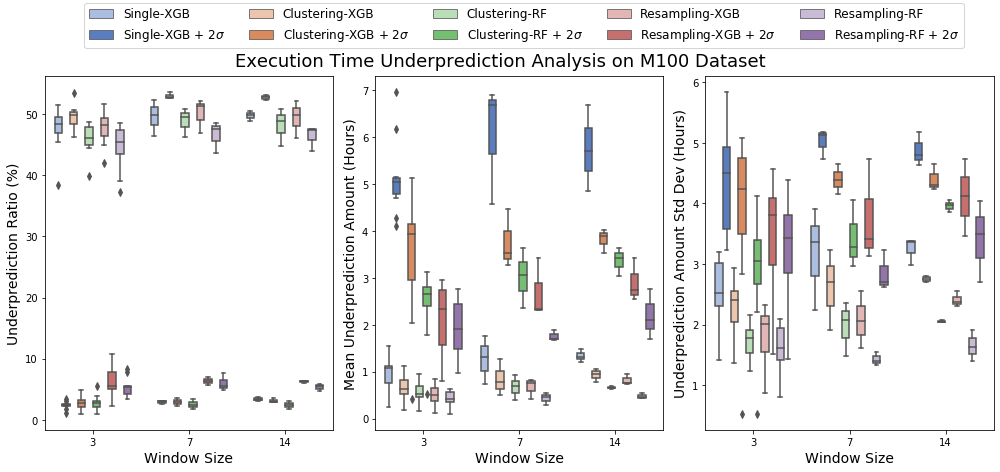

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

base_colors = sns.color_palette("muted", 5)

lighter_colors = [mcolors.to_rgb(c) for c in base_colors]
lighter_colors = [(r + 0.5*(1-r), g + 0.5*(1-g), b + 0.5*(1-b)) for r, g, b in lighter_colors]
custom_palette = [color for pair in zip(lighter_colors, base_colors) for color in pair]

plot_df["Model_Bias"] = plot_df["Model"] + " - " + plot_df["Bias"]

custom_labels = {
    'baseline - none': 'Single-XGB',
    'baseline - two_sigma': r'Single-XGB + $2\sigma$',
    'clustering_xgb - none': 'Clustering-XGB',
    'clustering_xgb - two_sigma': r'Clustering-XGB + $2\sigma$',
    'clustering_rf - none': 'Clustering-RF',
    'clustering_rf - two_sigma': r'Clustering-RF + $2\sigma$',
    'resampled_xgb - none': 'Resampling-XGB',
    'resampled_xgb - two_sigma': r'Resampling-XGB + $2\sigma$',
    'resampled_rf - none': 'Resampling-RF',
    'resampled_rf - two_sigma': r'Resampling-RF + $2\sigma$',
}

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[0]
)
axes[0].set_xlabel("Window Size", fontsize=14)
axes[0].set_ylabel("Underprediction Ratio (%)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_mean(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[1]
)
axes[1].set_xlabel("Window Size", fontsize=14)
axes[1].set_ylabel("Mean Underprediction Amount (Hours)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_std(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[2]
)
axes[2].set_xlabel("Window Size", fontsize=14)
axes[2].set_ylabel("Underprediction Amount Std Dev (Hours)", fontsize=14)



fig.suptitle("Execution Time Underprediction Analysis on M100 Dataset", fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

custom_labels_list = [custom_labels.get(label, label) for label in labels]

fig.legend(handles, custom_labels_list, loc='upper center', bbox_to_anchor=(0.52, 1.1), ncol=5, fontsize=12)

axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])

plot_name = 'boxplot_m100.svg'
file_path = os.path.join('/projectnb/peaclab-mon/boztop/resource-allocation/plots', plot_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Visualize underprediction distribution
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

models = ['baseline', 'clustering_xgb', 'resampled_xgb']
fig, axes = plt.subplots(1, len(models), figsize=(15, 4), sharey=True)

bounds = [0, 60*10, 60*60, 60*60*4, 60*60*12, 60*60*24, 60*60*24*10]
colors = plt.cm.plasma(np.linspace(0, 1, len(bounds) - 1))
line_colors = colors.copy()



for ax, model in zip(axes, models):
    ax.set_title(f'{model} Error Distribution')
    median_errors = {bound: [] for bound in bounds[:-1]}  # Store median errors for each bin
    total_underpred = 0
    total_jobs = 0

    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        df = df.copy()
        underpredictions = df[df['pred'] < df['act']].copy()
        total_underpred = total_underpred + len(underpredictions)
        total_jobs = total_jobs +  len(df)
        df.loc[:, 'error'] = df['act'] - df['pred']
        df.loc[:, 'abs_error'] = abs(df['error'])
        
        for i, bound in enumerate(bounds[:-1]):
            l_bound = bound
            r_bound = bounds[i + 1]
            color = colors[i]
            line_color = line_colors[i]

            error_sample = df[df.act.between(l_bound, r_bound, inclusive='right')].abs_error / 60
            ax.hist(error_sample, bins=np.logspace(-3, 4, 50), color=color, alpha=0.8)

            med_err = error_sample.median()
            if not np.isnan(med_err):  # Store median error only if valid
                median_errors[bound].append(med_err)

    # Plot median error lines after processing all start dates
    for i, bound in enumerate(bounds[:-1]):
        if median_errors[bound]:  # If there are valid medians
            med_err_final = np.median(median_errors[bound])  # Take median of medians
            med_err_label = 'minutes'
            if med_err_final > 60:
                med_err_final /= 60
                med_err_label = 'hours'

            # Format bounds label
            bound_label = '('
            for bound in (bounds[i], bounds[i + 1]):
                if bound < 60*60:
                    new_bound = f"{bound//60}m"
                elif bound < 60*60*24:
                    new_bound = f"{bound//(60*60)}h"
                else:
                    new_bound = f"{bound//(24*60*60)}d"
                bound_label += f"{new_bound}, "
            bound_label = bound_label[:-2] + ']'

            ax.vlines(med_err_final, 0, 250000, linestyle='--', color=line_colors[i], 
                      label=f'{bound_label} Med Err: {med_err_final:.1f} {med_err_label}')
    
    print(f"For Model {model}, there are {total_jobs} total jobs.\n")
    print(f"For Model {model}, there are {total_underpred} total underpredictions.\n")
    print(f"Success rate is, {100 * (1-total_underpred/total_jobs)}\n") 
    
    ax.set_xscale('log')
    ax.set_xlim(0.1, 10000)
    ax.set_ylim([0, 500])
    ax.legend(loc='upper left', prop={'family': 'DejaVu Sans Mono'})
    ax.set_xlabel('Absolute Error (minutes)',fontsize=14)
    if ax == axes[0]:
        ax.set_ylabel('Number of Jobs',fontsize=14)

plt.suptitle(r'Execution Time Absolute Error Results on M100 Dataset (with bias=2$\sigma$)', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

for model in models:
    total_user_req = 0
    total_pred = 0
    
    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
            
        df = df.copy()
        
        user_overpred = df[df['act'] < df['req']].copy()
        total_user_req += (user_overpred['req']  - user_overpred['act']).sum()
        
        overpred = df[df['act'] < df['pred']].copy()
        total_pred += (overpred['pred']  - overpred['act']).sum()
        
    print(f"Model: {model}")
    print(f"Total user request overprediction (hours): {total_user_req/3600}")
    print(f"Total model overprediction (hours): {total_pred/3600}")
        
        

    

# Demonstration of time limit request vs queue time

In [ ]:
# Demonstrating the queue wait time increases with increasing wait time

bins = [0, 0.1, 1, 2, 5, 10, 20, 50, 100]
labels = ['[0, 0.1]', '(0.1, 1]', '(1, 2]', '(2, 5]', '(5,10]', '(10,20]','(20,50]','(50,100]']

cleaned_df['wallclock_req_hour'] = cleaned_df['time_limit_sec'] / 3600
cleaned_df['wait_time_hour'] = cleaned_df['wait_time'] / 3600


cleaned_df['wallclock_category'] = pd.cut(cleaned_df['wallclock_req_hour'], bins=bins, labels=labels)

wait_time_means = cleaned_df.groupby('wallclock_category')['wait_time_hour'].mean()

plt.figure(figsize=(10, 6))
wait_time_means.plot(kind='bar', color='orange', edgecolor='black')

plt.xlabel('Requested Wallclock Time (hours)', fontsize=20)
plt.ylabel('Average Wait Time (hours)', fontsize=20)
plt.title('M100 Dataset: Average Wait Time by Requested Wallclock Time', fontsize=20)
plt.grid(True)

plt.xticks(rotation=45)
plt.xticks(fontsize=14)
plt.show()




# Analyzing SLURM plugin outputs

# CPU Information

In [ ]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_cpu_util/a_0.parquet'
cpu_util_df = pd.read_parquet(directory)
cpu_util_df = cpu_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.cpus_alloc/a_0.parquet'
cpu_alloc_df = pd.read_parquet(directory)
cpu_alloc_df = cpu_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.cpus_config/a_0.parquet'
cpu_config_df = pd.read_parquet(directory)
cpu_config_df = cpu_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


In [ ]:
def create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, partition):

    df_partition = cpu_config_df[cpu_config_df['partition'] == partition].merge(
        cpu_alloc_df[cpu_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        cpu_util_df[cpu_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    df_partition = df_partition.rename(columns={'value_config': 'cpu_config'})
    df_partition = df_partition.rename(columns={'value_alloc': 'cpu_alloc'})
    df_partition = df_partition.rename(columns={'value': 'cpu_util_percent'})
    df_partition['cpu_used'] = 0.01 * df_partition['cpu_alloc'] * df_partition['cpu_util_percent']
    
    return df_partition


In [ ]:
dataframes = [
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '0'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '1'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '2'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '3'),
    create_partition_df(cpu_config_df, cpu_alloc_df, cpu_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    cpu_config = np.array(df['cpu_config']).flatten()
    cpu_alloc = np.array(df['cpu_alloc']).flatten()
    cpu_used = np.array(df['cpu_used']).flatten()
    cpu_util_percent = df['cpu_util_percent'].values
    
    #axs[i].plot(timestamps, cpu_config, color='red', label='CPU Config', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, cpu_alloc, color='blue', label='Allocated CPU cores', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, cpu_used, color='orange', label='Utilized CPU cores', linestyle='--', linewidth=2)

    avg_utilization = cpu_util_percent.mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    axs[i].set_title(f"M100 Dataset, December 2021 CPU Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('CPU Cores')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



In [ ]:
cpu_configs = [df['cpu_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, cpu_configs, color='#5A9BD5')  # Darker pastel blue
ax.set_title('Configured CPU Cores per Partition')
ax.set_ylabel('Configured CPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()

# GPU Information

In [ ]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_gpu_util/a_0.parquet'
gpu_util_df = pd.read_parquet(directory)
gpu_util_df = gpu_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

min_value = gpu_util_df['value'].min()
max_value = gpu_util_df['value'].max()

print("Minimum value in 'value' column:", min_value)
print("Maximum value in 'value' column:", max_value)

directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.gpus_alloc/a_0.parquet'
gpu_alloc_df = pd.read_parquet(directory)
gpu_alloc_df = gpu_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.gpus_config/a_0.parquet'
gpu_config_df = pd.read_parquet(directory)
gpu_config_df = gpu_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)

gpu_util_df

In [ ]:
def gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, partition):
    df_partition = gpu_config_df[gpu_config_df['partition'] == partition].merge(
        gpu_alloc_df[gpu_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        gpu_util_df[gpu_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    
    df_partition = df_partition.rename(columns={
        'value_config': 'gpu_config',
        'value_alloc': 'gpu_alloc',
        'value': 'gpu_util_percent'
    })
    df_partition['gpu_used'] = df_partition['gpu_util_percent'] * df_partition['gpu_alloc'] * 0.01
    
    return df_partition


In [ ]:
df_p = gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '0')

df_p

In [ ]:

dataframes = [
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '0'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '1'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '2'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '3'),
    gpu_create_partition_df(gpu_config_df, gpu_alloc_df, gpu_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    gpu_alloc = np.array(df['gpu_alloc']).flatten()
    gpu_used = np.array(df['gpu_used']).flatten()
    
    #axs[i].plot(timestamps, gpu_req, color='blue', label='GPU Requested', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, gpu_alloc, color='red', label='GPU Alloc', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, gpu_used, color='green', label='GPU Utilization', linestyle='--', linewidth=2)

    avg_utilization_percent = df['gpu_util_percent'].mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization_percent:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    
    axs[i].set_title(f"M100 Dataset, December 2021 GPU Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('GPU Cores')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



In [ ]:
gpu_configs = [df['gpu_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, gpu_configs, color='#90EE90')  # Soft green
ax.set_title('Configured GPU Cores per Partition')
ax.set_ylabel('Configured GPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()

# Memory Information

In [ ]:
directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.cluster_mem_util/a_0.parquet'
mem_util_df = pd.read_parquet(directory)
mem_util_df = mem_util_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.memory_alloc/a_0.parquet'
mem_alloc_df = pd.read_parquet(directory)
mem_alloc_df = mem_alloc_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)


directory = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/m100/21_12_slurm/metric=s21.totals.memory_config/a_0.parquet'
mem_config_df = pd.read_parquet(directory)
mem_config_df = mem_config_df.sort_values(by=['partition', 'timestamp']).reset_index(drop=True)



In [ ]:
def mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, partition):

    df_partition = mem_config_df[mem_config_df['partition'] == partition].merge(
        mem_alloc_df[mem_alloc_df['partition'] == partition], on='timestamp', suffixes=('_config', '_alloc')
    ).merge(
        mem_util_df[mem_util_df['partition'] == partition], on='timestamp', suffixes=('', '_util')
    )
    
    df_partition = df_partition[['timestamp', 'partition', 'value_config', 'value_alloc', 'value']]
    df_partition = df_partition.rename(columns={'value_config': 'mem_config'})
    df_partition = df_partition.rename(columns={'value_alloc': 'mem_alloc'})
    df_partition = df_partition.rename(columns={'value': 'mem_util_percent'})
    df_partition['mem_used'] = 0.01 * df_partition['mem_alloc'] * df_partition['mem_util_percent']
    
    return df_partition


In [ ]:
dataframes = [
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '0'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '1'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '2'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '3'),
    mem_create_partition_df(mem_config_df, mem_alloc_df, mem_util_df, '5')
]

partitions = ['0', '1', '2', '3', '5']
fig, axs = plt.subplots(len(partitions), 1, figsize=(10, 8), sharex=True)

for i, partition in enumerate(partitions):
    df = dataframes[i]
    
    timestamps = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
    mem_config = np.array(df['mem_config']).flatten()
    mem_alloc = np.array(df['mem_alloc']).flatten()
    mem_used = np.array(df['mem_used']).flatten()
    mem_util_percent = df['mem_util_percent'].values
    
    axs[i].plot(timestamps, mem_alloc, color='#1f77b4', label='Allocated Memory (RAM)', linestyle='-', linewidth=2)
    axs[i].plot(timestamps, mem_used, color='#ff7f0e', label='Utilized Memory (RAM)', linestyle='--', linewidth=2)

    avg_utilization = mem_util_percent.mean()
    axs[i].text(0.95, 0.95, f"Avg Utilization: {avg_utilization:.2f}%", 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    axs[i].set_title(f"M100 Dataset, December 2021 Memory Utilization Analysis for Partition {partition}")
    axs[i].set_ylabel('Memory (RAM)')
    axs[i].legend(loc='upper left')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



In [ ]:
mem_configs = [df['mem_config'].unique()[0] for df in dataframes]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(partitions, mem_configs, color='#FFA07A')  # Soft orange
ax.set_title('Configured Memory(RAM) per Partition')
ax.set_ylabel('Configured GPU Cores')
ax.set_xlabel('Partition')

plt.tight_layout()
plt.show()